In [1]:
import re
from Tokenization.tokenization import CharacterTokenization
from TextFormatter.formatter import CharacterFormatter


 

# Load file
vocab_file = r"C:\Users\91978\Desktop\GPT-2-Scratch\dataset\Poems.txt"
with open(vocab_file, "r", encoding="utf-8") as f:
    text = f.read()

formatter = CharacterFormatter(text)
text = formatter.preprocess()

print("Original text length:", len(text))

# # Clean text before creating vocabulary
# text = re.sub(r'\d+', '', text)
# text = re.sub(r'[^\w\s]', '', text)  # remove special characters
# #remove greek characters
# text = re.sub(r'[α-ωΑ-Ω]', '', text)

vocab = sorted(list(set(text)))
print("Vocabulary size:", len(vocab))
print("First 10 characters:", vocab[:10])
print(vocab)

# Initialize tokenizer with clean vocab
tokenizer = CharacterTokenization(vocab)

# Test tokenization
test_text = "Hello World"
tokens = tokenizer.tokenize(test_text)
print("Tokens:", tokens)
decoded=tokenizer.detokenize(tokens)
print("Decoded:", decoded)

Original text length: 111
Vocabulary size: 111
First 10 characters: ['\t', '\n', ' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
['\t', '\n', ' ', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', '²', '³', '¹', '¾', 'À', 'Á', 'Ä', 'Æ', 'È', 'É', 'Ñ', 'Ô', 'Õ', 'Ü', 'Ý', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'Œ', 'œ', 'š', 'Ž', 'ž', 'ל', 'מ', 'ת', '饟']
Tokens: [10, 34, 41, 41, 44, 2, 25, 44, 47, 41, 33]
Decoded: Hello World


In [1]:
from Tokenization.tokenization import WordTokenization
from TextFormatter.formatter import CharacterFormatter, WordFormatter


 

# Load file
vocab_file = r"C:\Users\91978\Desktop\GPT-2-Scratch\dataset\Poems.txt"
with open(vocab_file, "r", encoding="utf-8") as f:
    text = f.read()

print("Original text length:", len(text))
# preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
word_formatter = WordFormatter(text)
preprocessed = word_formatter.preprocess()  
#remove number
# preprocessed = [word for word in preprocessed if not word.isdigit()]
# preprocessed = sorted(set(preprocessed))
print("Vocabulary size:", len(preprocessed))
print("Preprocessed text length:", preprocessed[:200])
word_tokenizer = WordTokenization(preprocessed)
test_text = "Hello World"
tokens = word_tokenizer.tokenize(test_text)
print("Tokens:", tokens)
decoded = word_tokenizer.detokenize(tokens)
print("Decoded:", decoded)

Original text length: 35370769
Vocabulary size: 146882
Preprocessed text length: ['ABBOT', 'ABC', 'ABNER', 'ABOARD', 'ABOLISHING', 'ABOUT', 'ABOVE', 'ABRAHAM', 'ABSENCE', 'ABSTRACTEDLY', 'AC', 'ACCENTS', 'ACCIDENT', 'ACCORD', 'ACCOST', 'ACCOUNT', 'ACHIHA', 'ACT', 'ACTO', 'ACTRESS', 'ACTS', 'AD', 'ADDRESSED', 'ADDRESSES', 'ADELE', 'ADIEU', 'ADIEUS', 'ADMIR', 'ADMIRATION', 'ADMIRE', 'ADMISSION', 'ADMIT', 'ADMITTANCE', 'ADONIS', 'ADOR', 'ADORATION', 'ADVERSITY', 'AE', 'AENEIDEM', 'AENEIDS', 'AETERNAL', 'AEUM', 'AEgis', 'AEneas', 'AEschylean', 'AEschylos', 'AEsop', 'AEther', 'AEtna', 'AFAR', 'AFFAIRS', 'AFFRONT', 'AFOOT', 'AFRICA', 'AFRICAN', 'AFTER', 'AFter', 'AGAIN', 'AGAINST', 'AGATHA', 'AGE', 'AGED', 'AGES', 'AGIB', 'AGLÄE', 'AGNES', 'AGONIES', 'AGWNWN', 'AH', 'AI', 'AID', 'AIDS', 'AIKIN', 'AIM', 'AIN', 'AIR', 'AIl', 'ALARM', 'ALASKAN', 'ALBANY', 'ALBATROSS', 'ALBEIT', 'ALBUM', 'ALCESTIS', 'ALCMAEON', 'ALEXANDER', 'ALEXIS', 'ALIEN', 'ALIVE', 'ALL', 'ALLEGORICAL', 'ALMORAN', 'ALMOST', '

In [2]:
from Tokenization.tokenization import GptTokenizer
gpt_tokenizer = GptTokenizer()
test_text = "Hello World"
tokens = gpt_tokenizer.encode(test_text)
print("Tokens:", tokens)
decoded = gpt_tokenizer.decode(tokens)
print("Decoded:", decoded)

Tokens: [15496, 2159]
Decoded: Hello World


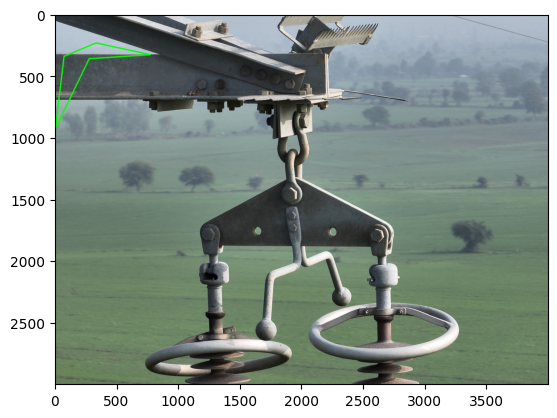

In [14]:
import cv2
import PIL
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_box(image_path, x, y):
    image = cv2.imread(image_path)
    pts = np.array([[x[i], y[i]] for i in range(len(x))], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=10)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

image_path = r"C:\Users\91978\Downloads\DJI_20240111151857_0109_V.JPG(1).JPG"
draw_bounding_box(image_path, 
                 [73, 332, 773, 277, 2],
                 [343, 234, 329, 362, 930])

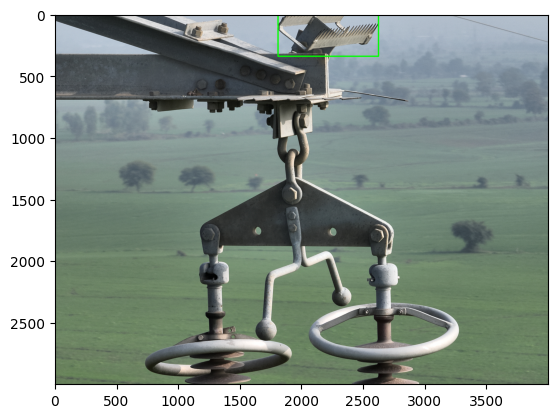

In [9]:
### create an function which will take the image as input which will return the boundary box of the image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def get_bounding_box(image_path):
    image = cv2.imread(image_path)
    pts = np.array([[1809.86669921875, 0], [2624.86669921875, 0], [2624.86669921875, 342], [1809.86669921875, 342]], np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=10)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

image_path = r"C:\Users\91978\Downloads\DJI_20240111151857_0109_V.JPG(1).JPG"
get_bounding_box(image_path)